In [1]:
pip install gymnasium

In [2]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.envs.registration import register
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/MyDrive/SP 25/Reinforcement Learning/PPO

/gdrive/MyDrive/SP 25/Reinforcement Learning/PPO


In [5]:
from MiniPacManGym import MiniPacManEnv

register(
    id="MiniPacMan-v0",
    entry_point=MiniPacManEnv,
    max_episode_steps=20
)

env = gym.make("MiniPacMan-v0", render_mode="human", frozen_ghost=False)

In [12]:
class CNN(nn.Module):
  def __init__(self, actions):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.fc1 = nn.Linear(6 * 6 * 64, 128)
    self.fc2 = nn.Linear(128, 4)

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)

    return x

In [13]:
pi_network = CNN(4)
optimizer = optim.Adam(pi_network.parameters(), lr=0.001)

In [14]:
M = 200
N = 200
gamma = 0.99
win_array = []

for e in range(M):
    B = []
    wins = 0

    for i in range(N):
        done = False
        truncated = False
        state, info = env.reset()
        trajectory = []

        while not done and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            action_probs = pi_network(state_tensor)
            action_probs = torch.clamp(action_probs, min=1e-8)
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, truncated, info = env.step(action)
            log_prob = torch.log(action_probs[0, action])

            trajectory.append((log_prob, reward))
            state = next_state

        if done and reward == 10:
            wins += 1

        #computing rewards to-go
        rewards = [r for (_, r) in trajectory]
        T = len(rewards)
        G = 0
        returns = [0]*T
        for t in reversed(range(T)):
            G = rewards[t] + gamma * G
            returns[t] = G

        for (log_prob, _), R_t in zip(trajectory, returns):
            B.append(log_prob * R_t)

    optimizer.zero_grad()
    loss = -torch.mean(torch.stack(B))
    loss.backward()
    optimizer.step()

    win_percentage = (wins / N) * 100
    win_array.append(win_percentage)
    print(f"[Update {e+1}/{M}] Win %: {win_percentage:.2f}%")


[Update 1/200] Win %: 0.00%
[Update 2/200] Win %: 0.00%
[Update 3/200] Win %: 0.00%
[Update 4/200] Win %: 0.00%
[Update 5/200] Win %: 0.00%
[Update 6/200] Win %: 0.00%
[Update 7/200] Win %: 0.50%
[Update 8/200] Win %: 1.50%
[Update 9/200] Win %: 2.00%
[Update 10/200] Win %: 3.00%
[Update 11/200] Win %: 2.00%
[Update 12/200] Win %: 2.50%
[Update 13/200] Win %: 4.00%
[Update 14/200] Win %: 7.50%
[Update 15/200] Win %: 5.00%
[Update 16/200] Win %: 8.00%
[Update 17/200] Win %: 10.50%
[Update 18/200] Win %: 8.50%
[Update 19/200] Win %: 9.00%
[Update 20/200] Win %: 12.50%
[Update 21/200] Win %: 10.50%
[Update 22/200] Win %: 11.50%
[Update 23/200] Win %: 15.00%
[Update 24/200] Win %: 12.00%
[Update 25/200] Win %: 13.50%
[Update 26/200] Win %: 15.00%
[Update 27/200] Win %: 12.50%
[Update 28/200] Win %: 15.50%
[Update 29/200] Win %: 14.50%
[Update 30/200] Win %: 17.50%
[Update 31/200] Win %: 12.00%
[Update 32/200] Win %: 17.50%
[Update 33/200] Win %: 17.50%
[Update 34/200] Win %: 22.00%
[Update

In [ ]:
obs, info = env.reset()
done = False
truncated = False

while not done and not truncated:
    env.render()
    obs=torch.tensor(obs,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    action_probs = pi_network(obs)
    action = torch.multinomial(action_probs, 1).item()

    obs, reward, done, truncated, info = env.step(action)
    sleep(1)
    clear_output(wait=True)

env.render()
env.close()

xxxxxx
x····x
x··ᗣ·x
x··ᗧ·x
x···◯x
xxxxxx



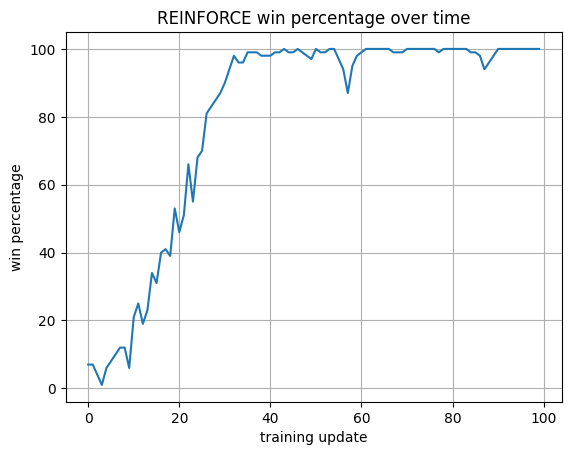

In [ ]:
plt.plot(range(M), win_array)
plt.xlabel('training update')
plt.ylabel('win percentage')
plt.title('REINFORCE win percentage over time')
plt.grid()
plt.show()